In [109]:
import os
import ot
from ot import emd2, emd  
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.9'
import jax
import jax.numpy as jnp
import numpy as np
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.nn import relu

from jax import lax
from jax.flatten_util import ravel_pytree
from jax import device_get

import itertools
from functools import partial
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [110]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
def MLP(layers, activation=jax.nn.sigmoid):
    ''' Vanilla MLP '''
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / jnp.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = jnp.zeros(d_out)
            return W, b

        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = jnp.dot(inputs, W) + b
            inputs = activation(outputs)
        W, b = params[-1]
        outputs = jnp.dot(inputs, W) + b
        return outputs

    return init, apply
    


In [22]:
def generate_points_in_circle(radius, center, num_points):
    points = []
    while len(points) < num_points:
        r = radius * np.sqrt(np.random.rand())  
        theta = np.random.rand() * 2 * np.pi
        x = center[0] + r * np.cos(theta)
        y = center[1] + r * np.sin(theta)
        points.append([x, y])
    return np.array(points)


def half_circles_points(num_points, eta):
    
    points = generate_points_in_circle(0.85, [0, 0], num_points)
    
    lpoints = points[np.where(points[:, 0] < 0)]
    rpoints = points[np.where(points[:, 0] >= 0)]
    
    lpoints[:, 0] = lpoints[:, 0] - eta / 2  
    rpoints[:, 0] = rpoints[:, 0] + eta / 2  
    return np.vstack((lpoints, rpoints))


def half_circles_points_bdd(radius, center, num_points, eta):
    points = []
    while len(points) < num_points:
        theta = np.random.rand() * np.pi - 0.5* np.pi
        x = center[0] +  np.cos(theta)*radius + eta/2
        y = center[1] +  np.sin(theta)*radius
        points.append([x, y])

        theta = np.random.rand() * np.pi + 0.5* np.pi
        x = center[0] +  np.cos(theta)*radius - eta/2
        y = center[1] +  np.sin(theta)*radius
        points.append([x, y])
       
        r = np.random.rand() * radius * 2 -radius
        x = center[0] + eta/2
        y = center[1] + r
        points.append([x, y])
        
        r = np.random.rand() * radius * 2 -radius
        x = center[0] -eta/2
        y = center[1] + r
        points.append([x, y])
    return np.array(points)



    
def input_generator_dis(eta, size=1000, rng_key=random.PRNGKey(1234)):
    n_dict = np.shape(eta)[0]
    input_ = jnp.zeros([n_dict, size, 3])
    
    for i in range(n_dict):
        source_points = half_circles_points(size, eta=eta[i])
        
        input_ = input_.at[i, :, 0:2].set(source_points)
        input_ = input_.at[i, :, 2].set(eta[i])    
    return input_


def boundary_generator_dis(eta, size=1000, rng_key=random.PRNGKey(1234)):
    n_dict = np.shape(eta)[0]
    input_ = jnp.zeros([n_dict, size, 3])
    
    for i in range(n_dict):
        source_points = half_circles_points_bdd(0.85,[0,0],size, eta=eta[i])
        input_ = input_.at[i, :, 0:2].set(source_points)
        input_ = input_.at[i, :, 2].set(eta[i])
    
    return input_

class TrainingDataGenerator_dis: 
    def __init__(self,foldername =None,size=5000, n_dict=1, batch_size=200, rng_key=random.PRNGKey(1234)):
        self.N = size
        self.data_set = jnp.zeros([n_dict, self.N, 5])
        self.key = rng_key
        eta = jnp.array(random.uniform(rng_key, shape=(n_dict,), minval=0, maxval=1.0))
        self.key, subkey = random.split(self.key)
        yy = generate_points_in_circle(0.85,[0,0],self.N)
        
        self.data_set = self.data_set.at[:, :, 3:5].set(yy)
        if foldername == None:
            for i_dict in range(n_dict):
                self.key, subkey = random.split(self.key)
                xx = input_generator_dis(eta, size=self.N, rng_key=subkey)
                self.data_set = self.data_set.at[i_dict, :, 0:3].set(xx[i_dict])

        else:
            self.data_set=jnp.load(foldername)

        self.batch_size = batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs= self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        key1, key2 = random.split(key)
        idx = random.choice(key1, self.N, (self.batch_size,), replace=False)
        inputs = self.data_set[:, idx, 0:3]
        idx2 = random.choice(key2, self.N, (self.batch_size,), replace=False)
        outputs = self.data_set[:, idx2, 3:5]
        return inputs, outputs

In [27]:
key = random.PRNGKey(6)
batch_size = 3000


key, key_s = random.split(key)
dataset = TrainingDataGenerator_dis(foldername=None,size=20000,n_dict=30,batch_size=batch_size, rng_key=key_s)



In [127]:
class DPNet:
    def __init__(self, width):
        self.net_init, self.net_apply = MLP(width, activation=jax.nn.relu)
        params = self.net_init(rng_key=random.PRNGKey(1234))
        

        self.opt_init, self.opt_update, self.get_params = optimizers.adam(
            optimizers.exponential_decay(1e-3, decay_steps=500, decay_rate=0.9))
        self.opt_state = self.opt_init(params)

       
        _, self.unravel_params = ravel_pytree(params)
        self.itercount = itertools.count()
     
       
        self.loss_log = [] 
        self.it_log = []
        self.folder_name=None        

    
    def fnet(self, params, x):
        outputs = self.net_apply(params, x)
        return outputs

    def distance_matrix(self, f, y):
        f1 = jnp.expand_dims(f, 2)
        y1 = jnp.expand_dims(y, 1)
        return jnp.sum(jnp.square(f1 - y1), 3)
        
        
    def DP_loss_mean(self, params, batch, gamma):
        x, y = batch     
        f = self.predict(params, x)     
        W2 = 0.5*jnp.sum(jnp.sum(self.distance_matrix(f,y)*gamma,-1),-1)
        W = jnp.mean(W2)
        W = jnp.sqrt(W)
        return jnp.mean(W)
        

    def emd_loss_mean(self, params, batch):
        x, y = batch
        f = self.predict(params, x)
        cost = 0.5*jnp.sum((f-x[...,:2])**2,-1)
        cost1 = jnp.mean(cost)
        cost2 = jnp.sqrt(cost1)
        return jnp.mean(cost2)
       

    def compute_full_loss(self, params, batch, gamma, lambda1):       
        DPloss = self.DP_loss_mean(params, batch, gamma)
        EMDloss = self.emd_loss_mean(params, batch)
        total_loss = DPloss + lambda1 * EMDloss        
        return total_loss
 

    def ref_map(self,x):
        f = x [...,:2]
        eta = x[..., 2] 
        f=f.at[...,0].set(jnp.heaviside(x[...,0],0)*(-eta ) + x[...,0] +(eta/2))
        return f

    
    def step_params(self, i, opt_state, batch, gamma, lambda1):
        params = self.get_params(opt_state) 
        g = grad(self.compute_full_loss)(params, batch, gamma,lambda1)
        return self.opt_update(i, g, opt_state)
        
    
    def cal_gamma(self, f,y, gamma):
        batch_size = f.shape[1]
        M = self.distance_matrix(f,y)
        weights = np.ones((batch_size,))*1.0/batch_size
        for ib in range(y.shape[0]):
            newvalgamma = ot.lp.emd(weights,weights, np.array(M[ib, :, :]))
            gamma = gamma.at[ib, :, :].set(newvalgamma) 
        return gamma


    def renew_batch(self, data_iter):
        batch = next(data_iter) 
        data_shape = batch[0].shape
        return batch


    def train(self, dataset, nIter=500, n_batch_renew=5, n_gamma_renew=5, n_print = 50, lambda1=0.6,checkpoint_interval=100):
        data_iter = iter(dataset)
        pbar = trange(nIter, smoothing=0) 
    
        for it in pbar:
            if it % n_batch_renew == 0: 
                batch = self.renew_batch(data_iter)                          
                data_shape = batch[0].shape
                gamma_fy = jnp.ones((data_shape[0], data_shape[1], data_shape[1])) * (1.0 / data_shape[1]) 
                                

            if it % n_gamma_renew == 0: 
                x, y = jax.device_get(batch) 
                params = self.get_params(self.opt_state) 
                f = self.predict(params,x)
                gamma_fy = self.cal_gamma(f,y,gamma_fy)
               

            self.opt_state = self.step_params(next(self.itercount), self.opt_state, batch, gamma_fy, lambda1)

            if it % n_print == 0:
                params = self.get_params(self.opt_state)
                DPloss = self.DP_loss_mean(params, batch, gamma_fy)
                EMDloss = self.emd_loss_mean(params, batch)
                total_loss= self.compute_full_loss( params, batch, gamma_fy, lambda1)
                                    
                self.loss_log.append(total_loss)
                self.it_log.append(it)
                pbar.refresh()
                description ="Tot: %.1e" % (total_loss)
                pbar.set_description(description)
                
                   
        x, y = batch
        params = self.get_params(self.opt_state)
        f=self.predict(params,x)
        return batch, f

    
    @partial(jit, static_argnums=(0,))
    def predict(self, params, x):
        pred = vmap(self.fnet, (None, 0))(params, x)+x[...,:2]
        return pred


In [128]:
m_in = 3
m_out = 2
layers = [m_in, 128,128,128, m_out]
lambda1=0.3
model = DPNet(layers) 
tempout = model.train(dataset,lambda1=lambda1,nIter=500,n_batch_renew=10,n_gamma_renew=10, n_print = 10)


  0%|                                                   | 0/500 [00:00<?, ?it/s]/home/lileduo/anaconda3/envs/venv/lib/python3.10/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
Tot: 8.4e-02: 100%|███████████████████████████| 500/500 [24:02<00:00,  2.89s/it]


In [9]:
def hist2dplot(x, y, ax1, labels=['1', '2'], xylims=None, vmin=None, vmax=None,cmap='viridis'):
    
    if xylims is None:
        H, xedges, yedges = np.histogram2d(x, y, 20, density=True)
    else:
        H, xedges, yedges = np.histogram2d(x, y, 20, density=True, 
                                         range=[[xylims[0], xylims[1]], 
                                               [xylims[2], xylims[3]]])
    H = H.T
    
    cax = ax1.pcolormesh(xedges, yedges, H, vmin=vmin, vmax=vmax,cmap='viridis')
    pbar = plt.colorbar(cax, ax=ax1)
    ax1.set_xlabel(labels[0],fontsize=12)
    ax1.set_ylabel(labels[1],fontsize=12)

    ax1.grid()
    
    return H, xedges, yedges



In [129]:
predict_size = 500000
rng_key=random.PRNGKey(41)
eta_value=[0.4]



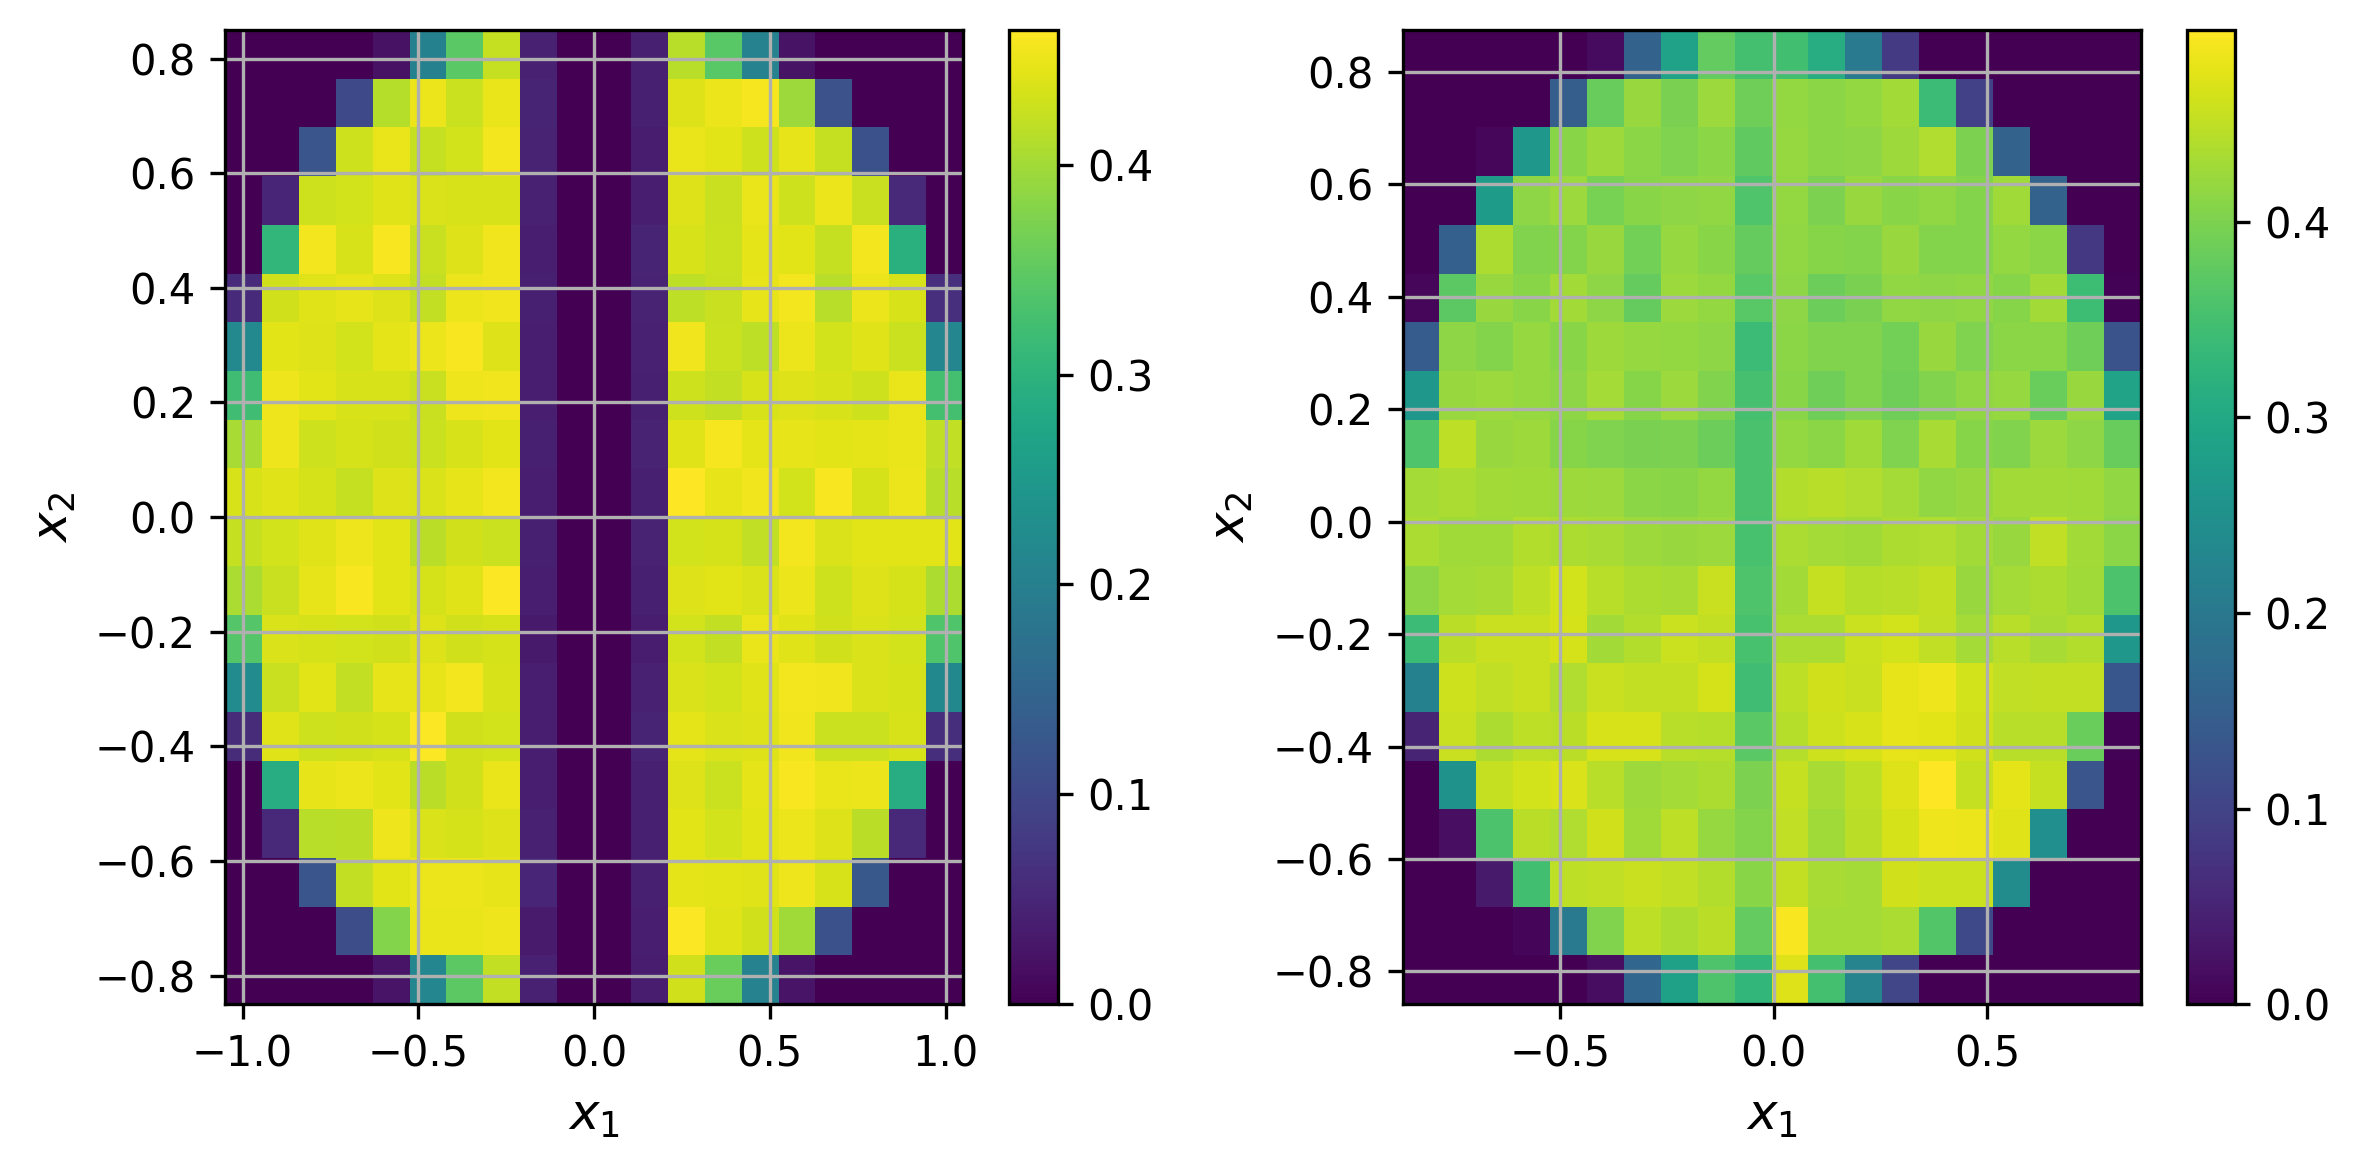

In [135]:
rng_key, subkey = random.split(rng_key)
xpre = input_generator_dis(eta=eta_value, size=predict_size, rng_key=subkey)
params = model.get_params(model.opt_state)
f_pred = jax.device_get(model.predict(params, xpre)) 


ref = model.ref_map(xpre[0, :, :]) 

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=300)

ax1 = axes[0]
hist2dplot(xpre[0,:, 0], xpre[0,:, 1], ax1, labels=[r"$x_1$", r"$x_2$"], cmap='viridis')


ax2 = axes[1]
hist2dplot(f_pred[0,:, 0], f_pred[0,:, 1], ax2, labels=[r"$x_1$", r"$x_2$"], cmap='viridis')

plt.tight_layout()
plt.show()


    
